In [1]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import layers

In [2]:
IMAGE_SIZE = [224, 224]

train_path = r'/kaggle/input/vm-7-2-1-split/Final/train_set'
test_path = r'/kaggle/input/vm-7-2-1-split/Final/test_set'
val_path = r'/kaggle/input/vm-7-2-1-split/Final/validation_set'


Total :  Found 87 files belonging to 2 classes.

For Training :  Found 87 images belonging to 2 classes.

For Val :  Found 12 images belonging to 2 classes.

For Test :  Found 26 images belonging to 2 classes.

No of Classes :  2
Classes :  ['nonvm', 'vm']
Image Shape :  (32, 256, 256, 3)


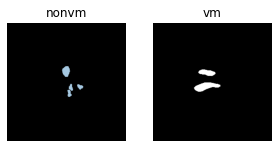

In [3]:
print("\nTotal : ", end=" ")
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(batch_size=32, directory=train_path)

train_datagen = ImageDataGenerator()

print("\nFor Training : ", end=" ")
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
#     batch_size=32,
    batch_size=128,
    class_mode='categorical')

print("\nFor Val : ", end=" ")
validation_generator = train_datagen.flow_from_directory(
    val_path,
    target_size=(224, 224),
#     batch_size=32,
    batch_size=4,
    class_mode='categorical',
    shuffle=False)
print("\nFor Test : ", end=" ")
test_generator = train_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
#     batch_size=32,
    batch_size=32,
    class_mode='categorical',
    shuffle=False)

class_names = train_dataset.class_names
noOfClasses = len(class_names)

print("\nNo of Classes : ", noOfClasses)
print("Classes : ", class_names)

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(noOfClasses):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

for image_batch, labels_batch in train_dataset:
    print("Image Shape : ",image_batch.shape)
    break

In [4]:
modelInput = tf.keras.applications.VGG16(
    input_shape=IMAGE_SIZE + [3],
    include_top=False,
    weights="imagenet"
)

for layer in modelInput.layers:
    layer.trainable = False

x = Flatten()(modelInput.output)
prediction = Dense(noOfClasses, activation='softmax')(x)

model = Model(inputs=modelInput.input, outputs=prediction)

model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [5]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('Brain MRI VGG16.h5', verbose=1, save_best_only=True)

In [6]:
epochs = 50
batchSize = 128

history = model.fit(
  train_generator,
  validation_data=validation_generator,
  epochs=epochs,
  batch_size=batchSize,
  callbacks=[annealer, checkpoint],
  steps_per_epoch=len(train_generator),
  validation_steps=len(validation_generator)
)

Epoch 1/50
1/1 [==============================] - 19s 19s/step - loss: 6.1630 - accuracy: 0.4943 - val_loss: 23.6784 - val_accuracy: 0.4167

Epoch 00001: val_loss improved from inf to 23.67838, saving model to Brain MRI VGG16.h5
Epoch 2/50
1/1 [==============================] - 6s 6s/step - loss: 19.2502 - accuracy: 0.4138 - val_loss: 10.6334 - val_accuracy: 0.4167

Epoch 00002: val_loss improved from 23.67838 to 10.63341, saving model to Brain MRI VGG16.h5
Epoch 3/50
1/1 [==============================] - 6s 6s/step - loss: 6.7225 - accuracy: 0.4483 - val_loss: 2.8411 - val_accuracy: 0.6667

Epoch 00003: val_loss improved from 10.63341 to 2.84107, saving model to Brain MRI VGG16.h5
Epoch 4/50
1/1 [==============================] - 6s 6s/step - loss: 0.8485 - accuracy: 0.8966 - val_loss: 11.9947 - val_accuracy: 0.5833

Epoch 00004: val_loss did not improve from 2.84107
Epoch 5/50
1/1 [==============================] - 6s 6s/step - loss: 4.4866 - accuracy: 0.7241 - val_loss: 13.3483 - v

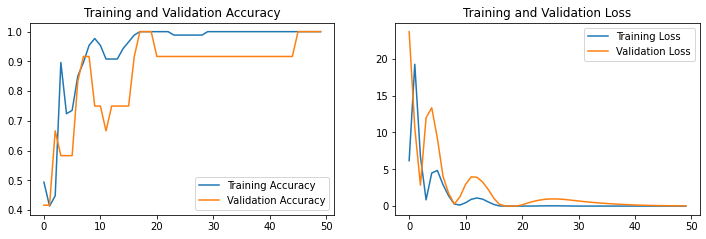

In [7]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(50)

plt.figure(figsize=(12, 12))
plt.subplot(3, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(3, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [8]:
evl = model.evaluate(test_generator)
acc = evl[1]*100
msg=f'Accuracy on the Test Set = {acc:5.2f} %'
print(msg)

model.save("Brain MRI - VGG16.h5")
print("Model Saved!")

1/1 [==============================] - 4s 4s/step - loss: 2.0141 - accuracy: 0.9231
Accuracy on the Test Set = 92.31 %
Model Saved!


## LIME

  0%|          | 0/1000 [00:00<?, ?it/s]

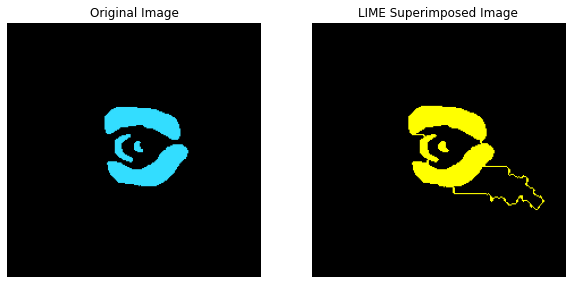

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from lime import lime_image
from skimage.segmentation import mark_boundaries
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

# Load VGG16 model pre-trained on ImageNet
# model = VGG16(weights='imagenet')

# Function to apply LIME to a sample image
def apply_lime(model, img_path):
    explainer = lime_image.LimeImageExplainer()

    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = preprocess_input(img_array)  # Preprocess input according to VGG16 requirements

    # Define the predict function for the model
    def predict_function(images):
        preds = model.predict(images)
        return preds

    # Explain the instance
    explanation = explainer.explain_instance(img_array, predict_function, top_labels=1, hide_color=0, num_samples=1000)

    # Get processed image
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)

    # Create superimposed image
    superimposed_img = mark_boundaries(temp / 2 + 0.5, mask)

    return superimposed_img

# Apply LIME to a sample image from the test set
sample_img_path = "/kaggle/input/vm-7-2-1-split/Final/train_set/vm/mask_78.png"
lime_img = apply_lime(model, sample_img_path)

# Display the original image and the LIME superimposed image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(tf.keras.preprocessing.image.load_img(sample_img_path, target_size=(224, 224)))  # Adjust target_size to match VGG16 input size
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(lime_img)
plt.title('LIME Superimposed Image')
plt.axis('off')

plt.show()

In [13]:
history.history['accuracy']

[0.49425286054611206,
 0.4137931168079376,
 0.4482758641242981,
 0.8965517282485962,
 0.7241379022598267,
 0.7356321811676025,
 0.8505747318267822,
 0.8965517282485962,
 0.954023003578186,
 0.977011501789093,
 0.954023003578186,
 0.9080459475517273,
 0.9080459475517273,
 0.9080459475517273,
 0.9425287246704102,
 0.9655172228813171,
 0.9885057210922241,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9885057210922241,
 0.9885057210922241,
 0.9885057210922241,
 0.9885057210922241,
 0.9885057210922241,
 0.9885057210922241,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

### Normal Gradcam try 

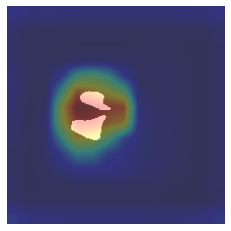

In [15]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image

# Load VGG16 with pre-trained weights
modelInput = tf.keras.applications.VGG16(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet"
)

# Freeze VGG16 layers
for layer in modelInput.layers:
    layer.trainable = False

# Add custom layers for classification
x = tf.keras.layers.Flatten()(modelInput.output)
x = tf.keras.layers.Dense(256, activation='relu')(x)
prediction = tf.keras.layers.Dense(noOfClasses, activation='softmax')(x)

# Define the model
model = Model(inputs=modelInput.input, outputs=prediction)

# Implement GradCAM
def grad_cam(model, img_path, layer_name):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    grad_model = Model([model.inputs], [model.get_layer(layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img_array)
        class_index = np.argmax(predictions[0])
        loss = predictions[:, class_index]

    grads = tape.gradient(loss, conv_output)[0]

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_output = conv_output[0]

    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_output), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    # Reshape heatmap to have an additional dimension
    heatmap = np.expand_dims(heatmap, axis=-1)

    # Get the shape of the original input image
    original_img = image.load_img(img_path, target_size=(224, 224))
    original_img_shape = original_img.size

    # Resize the heatmap to match the original input image size
    heatmap_resized = tf.image.resize(heatmap, original_img_shape, method='bilinear').numpy()

    # Normalize the heatmap for visualization
    heatmap_resized = heatmap_resized - np.min(heatmap_resized)
    heatmap_resized = heatmap_resized / np.max(heatmap_resized)

    plt.imshow(heatmap_resized[:,:,0], cmap='jet', alpha=0.6)  # Overlay heatmap on the image
    plt.imshow(original_img, alpha=0.5)  # Plot the original image
    plt.axis('off')
    plt.show()




# Choose an image for visualization
img_path = "/kaggle/input/vm-7-2-1-split/Final/train_set/vm/2259769_1_1_1_12.png"

# Specify the layer for GradCAM
layer_name = "block5_conv3"

# Generate GradCAM
grad_cam(model, img_path, layer_name)


## GRADCAM

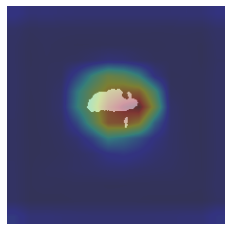

In [16]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image

# Load VGG16 with pre-trained weights
# modelInput = tf.keras.applications.VGG16(
#     input_shape=(224, 224, 3),
#     include_top=False,
#     weights="imagenet"
# )

# # Freeze VGG16 layers
# for layer in modelInput.layers:
#     layer.trainable = False

# # Add custom layers for classification
# x = tf.keras.layers.Flatten()(modelInput.output)
# x = tf.keras.layers.Dense(256, activation='relu')(x)
# prediction = tf.keras.layers.Dense(noOfClasses, activation='softmax')(x)

# # Define the model
# model = Model(inputs=modelInput.input, outputs=prediction)

# Implement GradCAM
def grad_cam(model, img_path, expected_class, layer_name):
    img = image.load_img(img_path, target_size=(224, 224))  # Resize the image to (224, 224)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    grad_model = Model([model.inputs], [model.get_layer(layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img_array)
        loss = predictions[:, expected_class]

    predicted_class = np.argmax(predictions[0])  # Predict the class using the model

    if predicted_class == expected_class:
        grads = tape.gradient(loss, conv_output)[0]

        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

        conv_output = conv_output[0]

        heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_output), axis=-1)
        heatmap = np.maximum(heatmap, 0)
        heatmap /= np.max(heatmap)

        # Reshape heatmap to have an additional dimension
        heatmap = np.expand_dims(heatmap, axis=-1)

        # Get the shape of the original input image
        original_img = image.load_img(img_path, target_size=(224, 224))
        original_img_shape = original_img.size

        # Resize the heatmap to match the original input image size
        heatmap_resized = tf.image.resize(heatmap, original_img_shape, method='bilinear').numpy()

        # Normalize the heatmap for visualization
        heatmap_resized = heatmap_resized - np.min(heatmap_resized)
        heatmap_resized = heatmap_resized / np.max(heatmap_resized)

        plt.imshow(heatmap_resized[:,:,0], cmap='jet', alpha=0.6)  # Overlay heatmap on the image
        plt.imshow(original_img, alpha=0.5)  # Plot the original image
        plt.axis('off')
        plt.show()
    else:
        # If predicted class doesn't match expected class, just display the original image
        plt.imshow(img)
        plt.axis('off')
        plt.show()

# Choose an image for visualization
# img_path = "/kaggle/input/new-masks-vm-and-nonvm/Final/train_set/vm/2259769_1_1_1_12.png"
img_path = "/kaggle/input/vm-7-2-1-split/Final/train_set/vm/mask_21.png"
# Specify the expected class (0 for ventriculomegaly, 1 for non-ventriculomegaly)
expected_class = 0

# Specify the layer for GradCAM
layer_name = "block5_conv3"

# Generate GradCAM
grad_cam(model, img_path, expected_class, layer_name)


In [20]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

# SHAP


In [26]:
import os
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions


In [27]:
image_dir = "/kaggle/input/vm-7-2-1-split/Final/train_set/vm"

# List to store images and labels
images = []
labels = []

# Iterate over the images in the directory
for filename in os.listdir(image_dir):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        # Load the image
        img = Image.open(os.path.join(image_dir, filename))
        # Preprocess the image (resize, convert to array, and apply preprocessing)
        img = img.resize((224, 224))  # Resize the image if needed
        img_array = np.array(img)
        img_array = preprocess_input(img_array)
        # Append the preprocessed image to the list of images
        images.append(img_array)
        # Extract the label from the filename (you'll need to customize this based on your filename format)
        label = filename.split("_")[0]  # Assuming the label is the first part of the filename before underscore
        labels.append(label)

# Convert the lists to numpy arrays
X = np.array(images)
y = np.array(labels)

# Print the shape of the arrays
print("Shape of X (images):", X.shape)
print("Shape of y (labels):", y.shape)

Shape of X (images): (36, 224, 224, 3)
Shape of y (labels): (36,)


In [28]:
import shap

# Define a function to preprocess the input image and pass it through the model
def f(x):
    tmp = x.copy()
    preprocess_input(tmp)
    return model(tmp)

# Define the masker
masker_blur = shap.maskers.Image("blur(128,128)", X[0].shape)

# Create the explainer
explainer_blur = shap.Explainer(f, masker_blur)

# Explain the SHAP values for the images
shap_values_fine = explainer_blur(
    X[1:6], max_evals=1000, batch_size=50, outputs=shap.Explanation.argsort.flip[:2]  # Changed to 2 classes
)


Partition explainer: 6it [00:30,  7.53s/it]                       


In [29]:
print(shap_values_fine.shape)

(5, 224, 224, 3, 2)


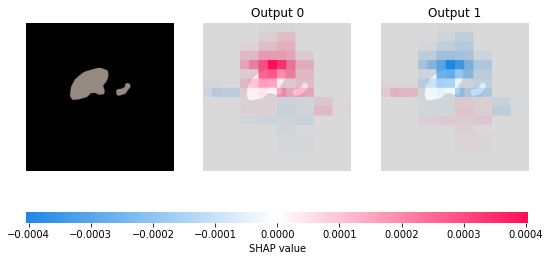

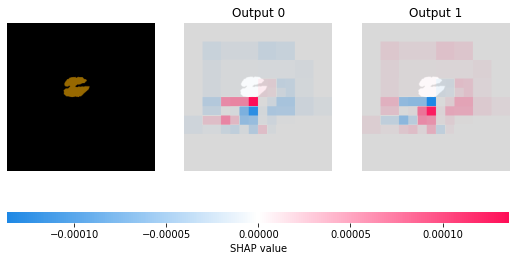

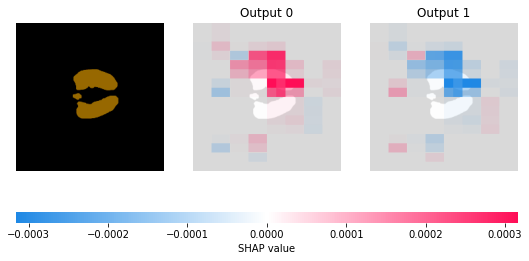

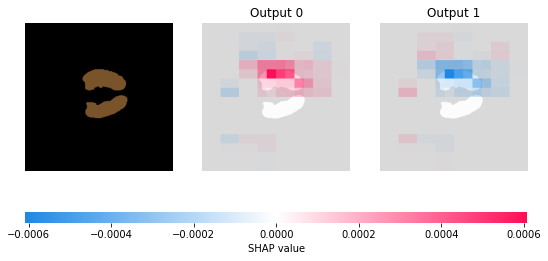

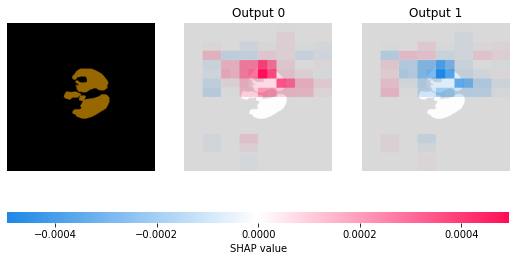

In [30]:
# Plot SHAP values for the first image and the first output class
for i in range(shap_values_fine.shape[0]):
        # Plot SHAP values for the current sample and output class
        shap.image_plot(shap_values_fine[i])


